## Import & Data Load

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [3]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

## Data Pre-processing

In [4]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


In [5]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# 데이터 읽기
data = train




# 필요한 열만 선택
selected_features = ['DIST', 'ID', 'BUILT', 'DEADWEIGHT', 
                     'GT', 'SHIPMANAGER', 'U_WIND','V_WIND', 
                     'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
                     'PORT_SIZE', 'month', 'day', 'hour', 'minute','CI_HOUR']

data = data[selected_features]

# 목표 변수 선택 (예: 'TARGET'는 목표 변수 컬럼 이름으로 변경해야 함)
target = data['CI_HOUR']
data = data.drop(columns=['CI_HOUR'])

train_data = train.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO','CI_HOUR'])


# 데이터 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# PCA 모델 생성 및 적용
n_components = 5
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# 주성분으로 이루어진 데이터프레임 생성
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i}' for i in range(1, n_components + 1)])

pca_df = pd.concat([train_data, pca_df], axis= 1)


# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(pca_df, target, test_size=0.2, random_state=42)

# XGBoost 모델 훈련
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 51.28719831627095


In [12]:
pca_df.head()

,DIST,ID,BUILT,DEADWEIGHT,GT,SHIPMANAGER,U_WIND,V_WIND,AIR_TEMPERATURE,ATA_LT,...,PORT_SIZE,month,day,hour,minute,PC1,PC2,PC3,PC4,PC5
0,30.736578,24337,28,73100,38600,591,0.14,3.77,15.9,12,...,0.001660,10,15,4,3,1.476621,-1.140157,-1.657419,-0.383795,-0.759181
1,63.220425,19552,15,37900,28100,723,-3.16,-6.72,24.5,10,...,0.001614,9,17,2,55,-0.825170,-0.270816,-1.098927,0.992037,-0.221799
2,90.427421,20449,7,115000,96400,2199,0.00,0.00,9.4,14,...,0.001743,2,23,6,43,0.978375,1.276715,0.375109,2.966690,0.752526
3,0.000000,1689,33,1490,700,3226,4.34,-7.31,22.1,7,...,0.000069,9,18,22,6,1.247960,-2.892414,0.639196,-2.210963,0.586171
4,8.813725,2989,10,27600,19300,3723,1.92,2.31,22.8,14,...,0.000197,8,13,12,57,-1.909765,0.284258,0.305532,-0.294091,-0.314683


In [16]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split




X = pca_df

y =  target


# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용하여 XGBoost 모델의 하이퍼파라미터 최적화를 수행하는 함수를 정의합니다.
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 500, 5000),
        'max_depth':trial.suggest_int('max_depth', 5, 30),
        'min_child_weight':trial.suggest_int('min_child_weight', 5, 30),
        'gamma':trial.suggest_int('gamma', 1, 20),
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        # 'learning_rate': 0.01,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        # 'lambda': trial.suggest_loguniform('lambda', 1e-3, 30.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0] ),
        'random_state': 42,
    }
    

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**params)

    # 모델을 학습합니다.
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행합니다.
    y_pred = model.predict(X_valid)

    # 평균 제곱 오차(MSE)를 계산하여 최소화하도록 최적화합니다.
    mse = mean_absolute_error(y_valid, y_pred)

    return mse

# Optuna 스터디를 생성하고 실행합니다.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials= 1000)  # 시행 횟수를 지정할 수 있습니다.

# 최적화된 하이퍼파라미터와 MSE 값을 출력합니다.
best_params = study.best_params
best_mse = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mse)

# 1차 시도 Best Hyperparameters: {'n_estimators': 3107, 'max_depth': 6, 'min_child_weight': 5,
#                         'gamma': 5, 'colsample_bytree': 1.0, 'lambda': 11.41761092170453, 
#                         'alpha': 1.2716284228296733, 'subsample': 1.0}
# Best MAE: 27.50373815914364


# Best Hyperparameters: {'n_estimators': 4725, 'max_depth': 5, 'min_child_weight': 5, 
#                        'gamma': 2, 'colsample_bytree': 1.0, 'alpha': 22.78782128332991, 'subsample': 1.0}
# Best MAE: 27.848691903819052

[I 2023-10-08 09:13:27,714] A new study created in memory with name: no-name-1baef0d7-4782-44b3-a6ea-f8886cbfcb00
C:\Users\User\AppData\Local\Temp\ipykernel_58332\3976153405.py:25: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
C:\Users\User\AppData\Local\Temp\ipykernel_58332\3976153405.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
[I 2023-10-08 09:13:51,513] Trial 0 finished with value: 37.45244643460676 and parameters: {'n_estimators': 1385, 'max_depth': 11, 'min_child_weight': 7, 'gamma': 1, 'colsample_bytree': 1.0, 'a

Best Hyperparameters: {'n_estimators': 4725, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 2, 'colsample_bytree': 1.0, 'alpha': 22.78782128332991, 'subsample': 1.0}
Best MAE: 27.848691903819052


# RandomForestRegressor + optuna

In [17]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = pca_df

y =  target


# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 대신 RandomForestRegressor를 사용
def objective(trial):
    params = {

        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'criterion': 'absolute_error',
        'max_depth' : trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 10),
        'min_weight_fraction_leaf': 0.0,
        'max_features': 1.0,
        'max_leaf_nodes': None,
        'min_impurity_decrease': 0.0,
        'bootstrap': True,
        'n_jobs': None,
        'random_state': 42
    
    }

    # RandomForestRegressor 모델을 생성
    model = RandomForestRegressor(**params)

    # 모델을 학습
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행
    y_pred = model.predict(X_valid)

    # 평균 제곱 오차(MAE)를 계산하여 최소화하도록 최적화
    mae = mean_absolute_error(y_valid, y_pred)

    return mae

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)  # 시행 횟수를 지정

# 최적화된 하이퍼파라미터와 MAE 값 출력
best_params = study.best_params
best_mae = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mae)


[I 2023-10-08 15:53:52,548] A new study created in memory with name: no-name-61a699ec-88a8-4907-902b-ba1fa309ff4b


# 다음은 딥러닝으로 구현해보기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# 데이터 읽기
data = train




# 필요한 열만 선택
selected_features = ['DIST', 'ID', 'BUILT', 'DEADWEIGHT', 
                     'GT', 'SHIPMANAGER', 'U_WIND','V_WIND', 
                     'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
                     'PORT_SIZE', 'month', 'day', 'hour', 'minute','CI_HOUR']

data = data[selected_features]

# 목표 변수 선택 (예: 'TARGET'는 목표 변수 컬럼 이름으로 변경해야 함)
target = data['CI_HOUR']
data = data.drop(columns=['CI_HOUR'])

train_data = train.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO','CI_HOUR'])


# 데이터 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# PCA 모델 생성 및 적용
n_components = 5
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# 주성분으로 이루어진 데이터프레임 생성
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i}' for i in range(1, n_components + 1)])

pca_df = pd.concat([train_data, pca_df], axis= 1)


# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(pca_df, target, test_size=0.2, random_state=42)

# XGBoost 모델 훈련
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 51.28719831627095


In [83]:
import xgboost as xgb  # 1. XGBoost 라이브러리 가져오기
import pandas as pd
from sklearn.model_selection import train_test_split


# X_train_reduced = train.drop(columns=['SHIP_TYPE_CATEGORY',  
#                                           'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
#                                           'LENGTH', 'SHIPMANAGER', 'FLAG', 
#                                           'V_WIND', 'AIR_TEMPERATURE',
#                                           'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
#                                           'minute','CI_HOUR'])
# X_test_reduced = test.drop(columns=['SHIP_TYPE_CATEGORY',  
#                                           'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
#                                           'LENGTH', 'SHIPMANAGER', 'FLAG',
#                                           'V_WIND', 'AIR_TEMPERATURE',
#                                           'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
#                                           'minute', ])
y_train = train['CI_HOUR']
X_train_reduced = train.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO','CI_HOUR'])
X_test_reduced = test.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO','CI_HOUR'])



y_train = train['CI_HOUR']

X_test_reduced = pd.concat([X_test_reduced, pca_df], axis= 1)

# 'CI_HOUR'을 타겟 변수로 선택
y =  y_train


# 'CI_HOUR' 열을 제외한 나머지 열을 특성으로 선택
X = X_train_reduced # X # .drop(columns = ['CI_HOUR'])


# train 데이터와 test 데이터로 나누기
X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.2,  random_state=42)


# 2. XGBoost 모델 선택 및 초기화
xgb_model = xgb.XGBRegressor( random_state=42)



# 3. XGBoost 모델 학습
xgb_model.fit(X_trains, y_trains)

# 4. XGBoost 모델 평가 - MAE 계산
xgb_pred = xgb_model.predict(X_tests)
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE:", xgb_mae)


XGBoost 모델의 MAE: 45.3649526809987


In [106]:
X_train_reduced.columns

Index(['DIST', 'U_WIND', 'month', 'weekday'], dtype='object')

In [109]:
X_train_reduced.head()

,ARI_CO,ARI_PO,DIST,ID,DEADWEIGHT,GT,DUBAI,BDI_ADJ,PORT_SIZE,year,day
0,4,13,30.736578,24337,73100,38600,42.01,1407.668330,0.001660,2020,15
1,4,14,63.220425,19552,37900,28100,67.53,2089.046774,0.001614,2019,17
2,4,45,90.427421,20449,115000,96400,65.30,603.193047,0.001743,2019,23
3,8,75,0.000000,1689,1490,700,43.02,1169.853455,0.000069,2020,18
4,16,46,8.813725,2989,27600,19300,90.45,1107.944894,0.000197,2022,13


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152:

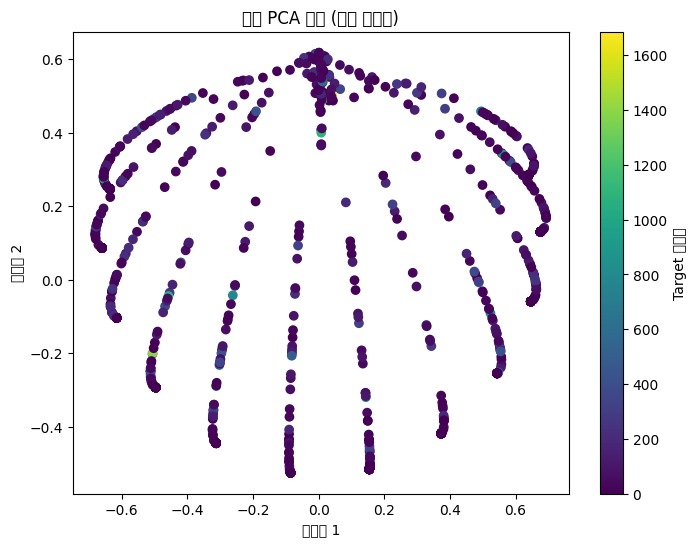

In [11]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X_train_reduced = train[['DIST',"month"]]

y_train = train['CI_HOUR']

# 데이터 표준 스케일링 (Standard Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)

# 목표 변수
y_train = train['CI_HOUR']

# 데이터 샘플링 (일부 데이터만 사용)
sample_size = 1000  # 원하는 샘플 크기로 조정
X_train_sampled = X_train_scaled[:sample_size]
y_train_sampled = y_train[:sample_size]

# 커널 PCA 설정
kpca = KernelPCA(kernel='rbf')  # RBF 커널을 사용하고 gamma 매개변수를 설정합니다.

# 데이터를 고차원 공간으로 매핑하고 주성분을 추출
X_kpca = kpca.fit_transform(X_train_sampled)

# 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_train_sampled, cmap='viridis')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.title('커널 PCA 결과 (샘플 데이터)')
plt.colorbar(label='Target 클래스')
plt.show()


In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train_reduced = train.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO','CI_HOUR'])

X_test_reduced = test.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO','CI_HOUR'])



y_train = train['CI_HOUR']



X_test_reduced = pd.concat([X_test_reduced, pca_df], axis= 1)

# 1. 테스트 데이터 불러오기
test_data = X_test_reduced  # 테스트 데이터 파일 경로를 지정하세요.

# 2. 테스트 데이터 전처리 (필요한 전처리 과정을 X_test에 적용)
X_test = test_data # 테스트 데이터에서 'CI_HOUR' 열을 제외하거나 필요한 열만 선택
# 나머지 전처리 단계를 동일하게 적용 (예: 스케일링, 원핫 인코딩 등)

# 3. 랜덤 포레스트 모델을 사용하여 예측 수행
rf_pred = rf_pred = xgb_model.predict(X_test)

# # 예측 결과를 원하는 형식으로 저장하거나 활용할 수 있습니다.
# # 예를 들어, DataFrame으로 저장하고 CSV 파일로 내보낼 수 있습니다.
# predictions_df = pd.DataFrame({'Predicted_CI_HOUR': rf_pred})
# predictions_df.to_csv('predictions.csv', index=False)  # 예측 결과를 'predictions.csv' 파일로 저장


ValueError: Feature shape mismatch, expected: 12, got 11

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = rf_pred
submit.to_csv('E:/ship/ship/models/baseline_submit_mse_15.csv', index=False)

In [5]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

In [6]:
train.describe()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
count,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,...,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000,367441.000000
mean,8.214067,44.819359,1.109803,19.315929,12379.237094,30.550239,14.746082,63588.867056,16.476540,11.086708,...,63.209494,1348.251333,0.000877,61.877118,2019.083692,6.441037,15.746414,10.970335,31.070994,2.402750
std,6.391924,28.727802,1.020394,30.903272,7180.922464,10.957426,7.040392,63558.705308,6.047007,4.600014,...,20.630433,738.961048,0.000838,170.575224,2.415262,3.457151,8.755559,7.017008,18.257719,1.819206
min,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,100.000000,0.000000,0.000000,...,-37.630000,286.802297,0.000005,0.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,21.000000,0.000000,0.000000,6079.000000,20.000000,10.000000,14400.000000,10.000000,10.000000,...,48.360000,836.349201,0.000142,0.000000,2017.000000,3.000000,8.000000,5.000000,15.000000,1.000000
50%,6.000000,39.000000,1.000000,6.929929,12473.000000,30.000000,13.000000,47400.000000,20.000000,10.000000,...,59.140000,1187.573732,0.000552,7.949444,2019.000000,6.000000,16.000000,10.000000,32.000000,2.000000
75%,16.000000,66.000000,2.000000,25.693063,18653.000000,40.000000,18.000000,81400.000000,20.000000,10.000000,...,74.250000,1660.987616,0.001614,49.153333,2021.000000,9.000000,23.000000,17.000000,48.000000,4.000000
max,24.000000,102.000000,3.000000,199.980651,24763.000000,60.000000,80.000000,404000.000000,30.000000,20.000000,...,123.700000,4795.865609,0.002615,2159.130556,2023.000000,12.000000,31.000000,23.000000,59.000000,6.000000


## 모델 학습 및 특성 중요도 확인

Model Tune for RandomForestRegressor.


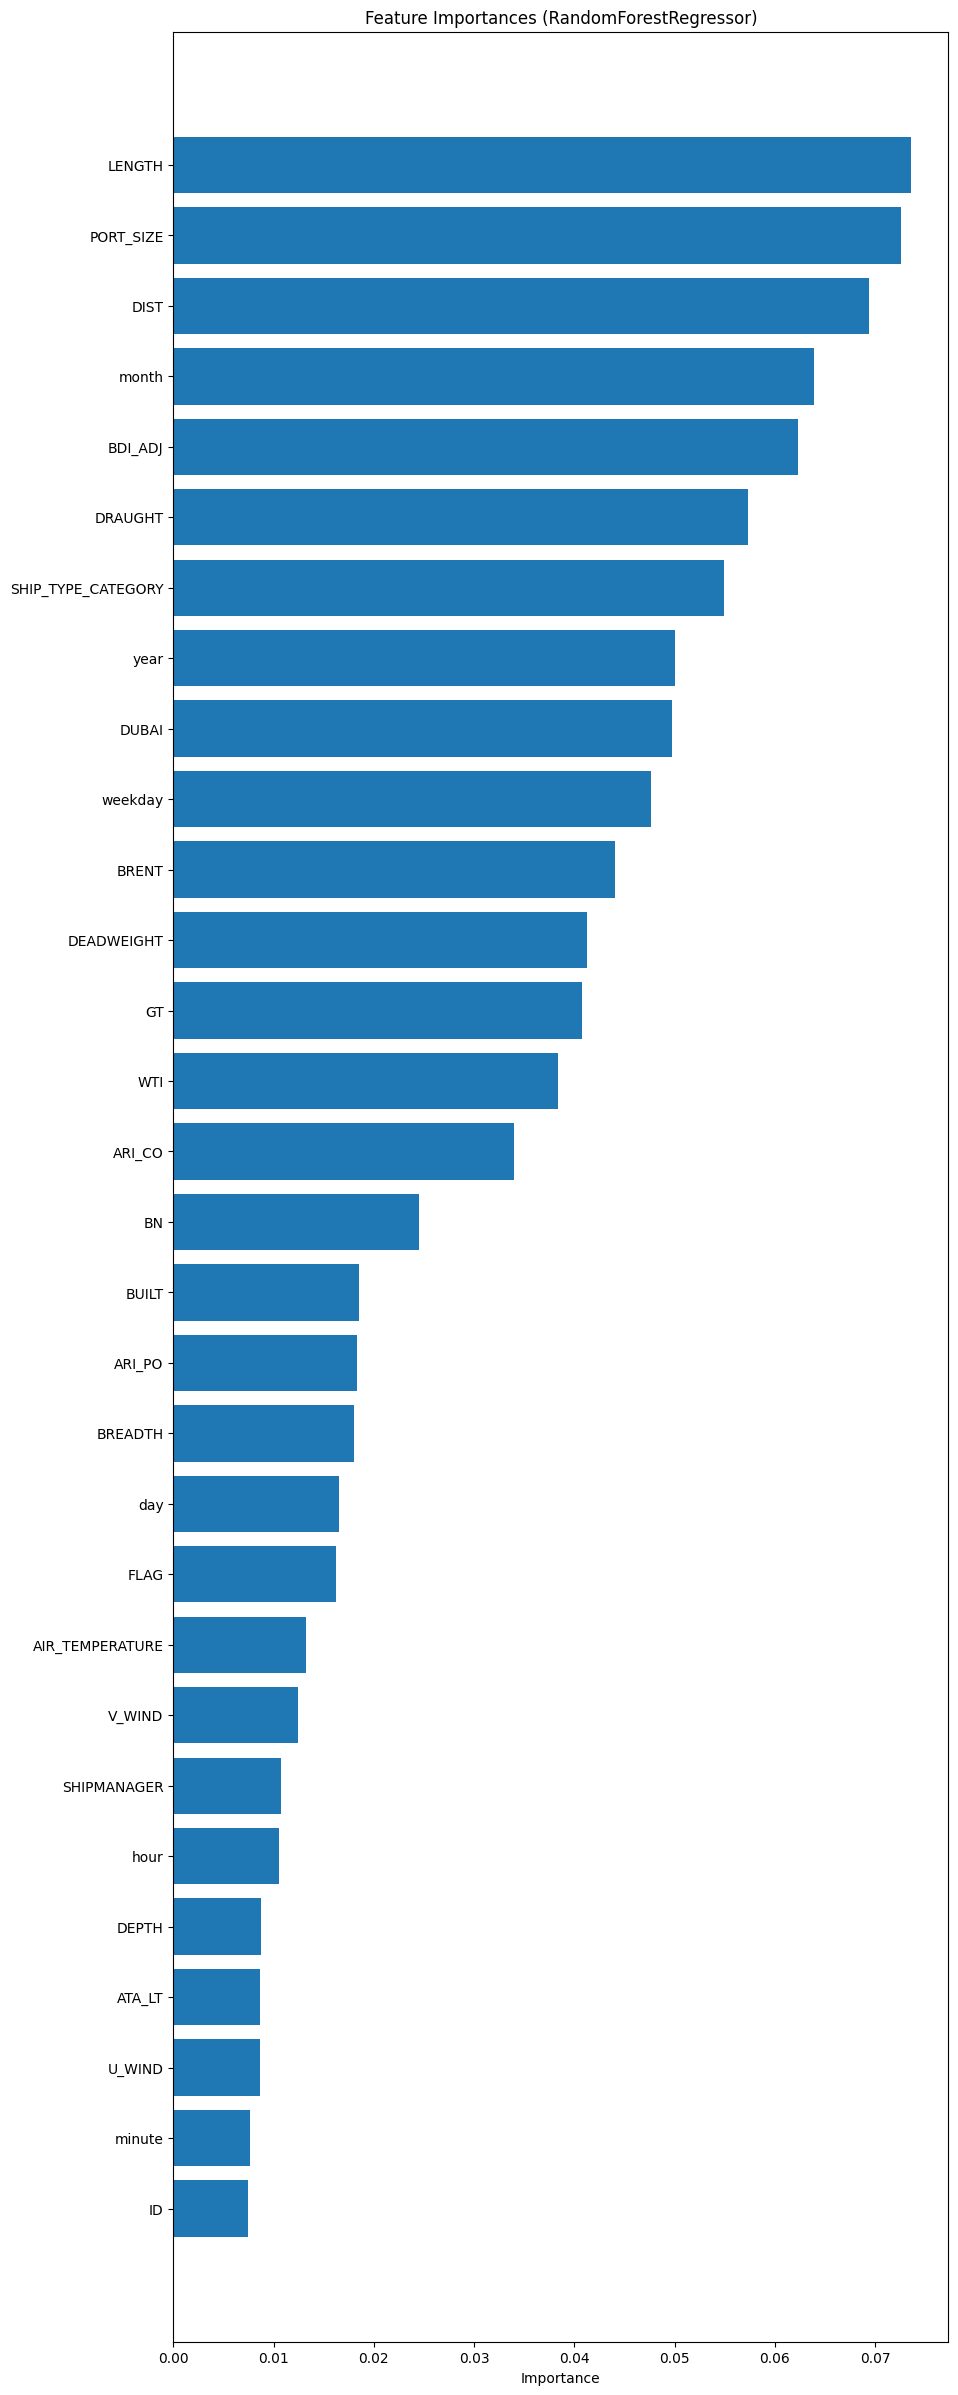

In [7]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
xgb_model = xgb.XGBRegressor(random_state=42)



def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(xgb_model, 
                                                        'RandomForestRegressor', X_train, y_train)

## 특징 중요도로 부터 feature sections

In [12]:
threshold = 0.023 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [19]:
X_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  int32  
 1   SHIP_TYPE_CATEGORY  367441 non-null  int32  
 2   DIST                367441 non-null  float64
 3   DEADWEIGHT          367441 non-null  int64  
 4   DRAUGHT             367441 non-null  float64
 5   GT                  367441 non-null  int64  
 6   LENGTH              367441 non-null  float64
 7   BN                  367441 non-null  float64
 8   DUBAI               367441 non-null  float64
 9   BRENT               367441 non-null  float64
 10  WTI                 367441 non-null  float64
 11  BDI_ADJ             367441 non-null  float64
 12  PORT_SIZE           367441 non-null  float64
 13  year                367441 non-null  int32  
 14  month               367441 non-null  int32  
 15  weekday             367441 non-nul

In [20]:
X_test_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244989 entries, 0 to 244988
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              244989 non-null  int32  
 1   SHIP_TYPE_CATEGORY  244989 non-null  int32  
 2   DIST                244989 non-null  float64
 3   DEADWEIGHT          244989 non-null  int64  
 4   DRAUGHT             244989 non-null  float64
 5   GT                  244989 non-null  int64  
 6   LENGTH              244989 non-null  float64
 7   BN                  244989 non-null  float64
 8   DUBAI               244989 non-null  float64
 9   BRENT               244989 non-null  float64
 10  WTI                 244989 non-null  float64
 11  BDI_ADJ             244989 non-null  float64
 12  PORT_SIZE           244989 non-null  float64
 13  year                244989 non-null  int32  
 14  month               244989 non-null  int32  
 15  weekday             244989 non-nul

In [15]:
# print(X_train_reduced)

In [23]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 367441 entries, 0 to 367440
Series name: CI_HOUR
Non-Null Count   Dtype  
--------------   -----  
367441 non-null  float64
dtypes: float64(1)
memory usage: 2.8 MB


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 'CI_HOUR'을 타겟 변수로 선택
y =  y_train

# 'CI_HOUR' 열을 제외한 나머지 열을 특성으로 선택
X = X_train_reduced# .drop(columns = ['CI_HOUR'])

# train 데이터와 test 데이터로 나누기
X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.2,  random_state=42)

# 이제 X_train, X_test, y_train, y_test를 사용하여 머신러닝 모델을 학습하고 평가할 수 있습니다.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 모델 선택 및 초기화
rf_model = RandomForestRegressor(random_state=42)

# 모델 학습
rf_model.fit(X_trains, y_trains)

# 모델 평가 - MAE 계산
rf_pred = rf_model.predict(X_tests)
rf_mae = mean_absolute_error(y_tests, rf_pred)
print("랜덤 포레스트 모델의 MAE:", rf_mae)

랜덤 포레스트 모델의 MAE: 55.328176575131295


In [24]:
import xgboost as xgb  # 1. XGBoost 라이브러리 가져오기

# 2. XGBoost 모델 선택 및 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# 3. XGBoost 모델 학습
xgb_model.fit(X_trains, y_trains)

# 4. XGBoost 모델 평가 - MAE 계산
xgb_pred = xgb_model.predict(X_tests)
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE:", xgb_mae)


XGBoost 모델의 MAE: 46.24400219608409


In [25]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_trains, y_trains)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_trains, y_trains)

# 각 모델에서 예측 생성
xgb_pred = xgb_model.predict(X_tests)
rf_pred = rf_model.predict(X_tests)

# 앙상블 예측 생성 (간단한 평균 사용)
ensemble_pred = (xgb_pred + rf_pred) / 2

# 앙상블 예측 평가 - MAE 계산
ensemble_mae = mean_absolute_error(y_tests, ensemble_pred)
print("앙상블 모델의 MAE:", ensemble_mae)
# 앙상블 모델의 MAE: 50.64919581566092

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_trains, y_trains)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_trains, y_trains)

# 각 모델에서 예측 생성
xgb_pred = xgb_model.predict(X_tests)
rf_pred = rf_model.predict(X_tests)

# 가중치 설정
xgb_weight = 0.7  # XGBoost 모델에 대한 가중치
rf_weight = 0.3   # RandomForest 모델에 대한 가중치

# 가중 평균을 사용하여 앙상블 예측 생성
ensemble_pred = (xgb_weight * xgb_pred) + (rf_weight * rf_pred)

# 앙상블 예측 평가 - MAE 계산
ensemble_mae = mean_absolute_error(y_tests, ensemble_pred)
print("가중치를 사용한 앙상블 모델의 MAE:", ensemble_mae)
# 
# 가중치를 사용한 앙상블 모델의 MAE: 49.39117675151707

가중치를 사용한 앙상블 모델의 MAE: 49.39117675151707


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': np.arange(100, 2001, 100),      # 100부터 1000까지 100 단위로
    'learning_rate': np.arange(0.01, 0.11, 0.01),  # 0.01부터 0.1까지 0.01 단위로
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],                 # 정수값 목록
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],         # 정수값 목록
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],            # 실수값 목록
    'subsample': np.arange(0.7, 1.01, 0.05),      # 0.7부터 1까지 0.05 단위로
    'colsample_bytree': np.arange(0.7, 1.01, 0.05)  # 0.7부터 1까지 0.05 단위로
}

# 랜덤 서치를 사용하여 하이퍼파라미터 최적화
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,       # 총 실험 횟수
    scoring='neg_mean_absolute_error',  # 평가 지표 (MAE)
    cv=5,            # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1        # 병렬 처리 사용
)

# 랜덤 서치 실행
random_search.fit(X_trains, y_trains)

# 최적의 하이퍼파라미터 조합 출력
print("최적의 하이퍼파라미터 조합:", random_search.best_params_)

# 최적 모델로 예측 수행
xgb_best_model = random_search.best_estimator_
xgb_pred = xgb_best_model.predict(X_tests)

# MAE 계산
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE (최적 하이퍼파라미터):", xgb_mae)


최적의 하이퍼파라미터 조합: {'subsample': 0.9500000000000002, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.09999999999999999, 'gamma': 0.4, 'colsample_bytree': 0.7}
XGBoost 모델의 MAE (최적 하이퍼파라미터): 37.37617042555383


In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정 (위와 동일하게 설정)
# 탐색할 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),      # 100부터 1000까지 100 단위로
    'learning_rate': np.arange(0.01, 0.11, 0.01),  # 0.01부터 0.1까지 0.01 단위로
    'max_depth': [3, 4, 5, 6, 7],                 # 정수값 목록
    'min_child_weight': [1, 2, 3, 4, 5],         # 정수값 목록
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],            # 실수값 목록
    'subsample': np.arange(0.7, 1.01, 0.05),      # 0.7부터 1까지 0.05 단위로
    'colsample_bytree': np.arange(0.7, 1.01, 0.05)  # 0.7부터 1까지 0.05 단위로
}

# 랜덤 서치를 사용하여 XGBoost 모델의 하이퍼파라미터 최적화
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions = param_dist,
    n_iter=50,       # 총 실험 횟수
    scoring='neg_mean_absolute_error',  # 평가 지표 (MAE)
    cv=5,            # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1        # 병렬 처리 사용
)

# 랜덤 서치 실행
xgb_random_search.fit(X_trains, y_trains)

# 최적의 XGBoost 하이퍼파라미터 조합 출력
print("최적의 XGBoost 하이퍼파라미터 조합:", xgb_random_search.best_params_)

# 최적 XGBoost 모델로 예측 수행
xgb_best_model = xgb_random_search.best_estimator_
xgb_pred = xgb_best_model.predict(X_tests)

# MAE 계산
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE (최적 하이퍼파라미터):", xgb_mae)

# RandomForest 모델 초기화
rf_model = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정 (위와 동일하게 설정)
# 탐색할 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),      # 100부터 1000까지 100 단위로
    'max_depth': [3, 4, 5, 6, 7],                 # 정수값 목록
    'min_samples_split': [2, 5, 10],              # 정수값 목록
    'min_samples_leaf': [1, 2, 4],               # 정수값 목록
    'max_features': ['auto', 'sqrt'],             # 문자열 목록
    'n_jobs': [-1]                               # 병렬 처리 사용
}



# 랜덤 서치를 사용하여 RandomForest 모델의 하이퍼파라미터 최적화
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,       # 총 실험 횟수
    scoring='neg_mean_absolute_error',  # 평가 지표 (MAE)
    cv=5,            # 교차 검증 폴드 수
    random_state=42,
    n_jobs=-1        # 병렬 처리 사용
)

# 랜덤 서치 실행
rf_random_search.fit(X_trains, y_trains)

# 최적의 RandomForest 하이퍼파라미터 조합 출력
print("최적의 RandomForest 하이퍼파라미터 조합:", rf_random_search.best_params_)

# 최적 RandomForest 모델로 예측 수행
rf_best_model = rf_random_search.best_estimator_
rf_pred = rf_best_model.predict(X_tests)

# MAE 계산
rf_mae = mean_absolute_error(y_tests, rf_pred)
print("RandomForest 모델의 MAE (최적 하이퍼파라미터):", rf_mae)

# 가중치 설정
xgb_weight = 0.8  # XGBoost 모델에 대한 가중치
rf_weight = 0.2  # RandomForest 모델에 대한 가중치

# 가중 평균 앙상블
ensemble_pred = (xgb_weight * xgb_pred) + (rf_weight * rf_pred)

# 앙상블 예측의 MAE 계산
ensemble_mae = mean_absolute_error(y_tests, ensemble_pred)
print("가중 평균 앙상블 모델의 MAE:", ensemble_mae)


최적의 XGBoost 하이퍼파라미터 조합: {'subsample': 0.9500000000000002, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.09999999999999999, 'gamma': 0.4, 'colsample_bytree': 0.7}
XGBoost 모델의 MAE (최적 하이퍼파라미터): 37.37617042555383


In [ ]:
test.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BRENT,WTI,BDI_ADJ,PORT_SIZE,year,month,day,hour,minute,weekday
0,9,26,4,9.508139,16893,20.0,9,5510,10.0,10.0,...,96.49,89.55,766.977634,0.000256,2022,8,27,8,29,5
1,18,22,3,24.186684,5749,40.0,14,109000,20.0,10.0,...,104.64,100.60,1655.006791,0.002615,2022,3,27,20,57,6
2,20,14,2,0.000000,15244,20.0,14,13700,10.0,10.0,...,84.98,79.48,682.595117,0.000427,2023,1,18,2,6,2
3,9,26,1,0.000000,1314,10.0,18,2840,10.0,10.0,...,41.80,39.51,629.378100,0.000256,2016,8,2,0,59,1
4,18,22,3,19.834186,8870,30.0,23,30700,20.0,10.0,...,86.13,80.13,563.101921,0.002615,2023,1,24,0,27,1


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. 테스트 데이터 불러오기
test_data = test  # 테스트 데이터 파일 경로를 지정하세요.

# 2. 테스트 데이터 전처리 (필요한 전처리 과정을 X_test에 적용)
X_test = test_data # 테스트 데이터에서 'CI_HOUR' 열을 제외하거나 필요한 열만 선택
# 나머지 전처리 단계를 동일하게 적용 (예: 스케일링, 원핫 인코딩 등)

# 3. 랜덤 포레스트 모델을 사용하여 예측 수행
rf_pred = ensemble_pred.predict(X_test)

# # 예측 결과를 원하는 형식으로 저장하거나 활용할 수 있습니다.
# # 예를 들어, DataFrame으로 저장하고 CSV 파일로 내보낼 수 있습니다.
# predictions_df = pd.DataFrame({'Predicted_CI_HOUR': rf_pred})
# predictions_df.to_csv('predictions.csv', index=False)  # 예측 결과를 'predictions.csv' 파일로 저장


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = rf_pred
submit.to_csv('./baseline_submit_1.csv', index=False)

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # 데이터 불러오기
# data = train# 데이터 파일 경로를 지정하세요.

# # 'CI_HOUR'을 타겟 변수로 선택
# y = data['CI_HOUR']

# # 'CI_HOUR' 열을 제외한 나머지 열을 특성으로 선택
# X = data.drop(columns=['CI_HOUR'])

# # train 데이터와 test 데이터로 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# # 이제 X_train, X_test, y_train, y_test를 사용하여 머신러닝 모델을 학습하고 평가할 수 있습니다.


## 이상치 제거
## scale
## feature section
## 앙상블
## atouai

In [ ]:
# 모델 평가 - MAE 계산
from sklearn.metrics import mean_absolute_error

평균 절대 오차 (MAE): 72.47409695071961


In [ ]:
# ##Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
#        'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
#        'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
#        'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
#        'year', 'month', 'day', 'hour', 'minute', 'weekday'],
#       dtype='object')

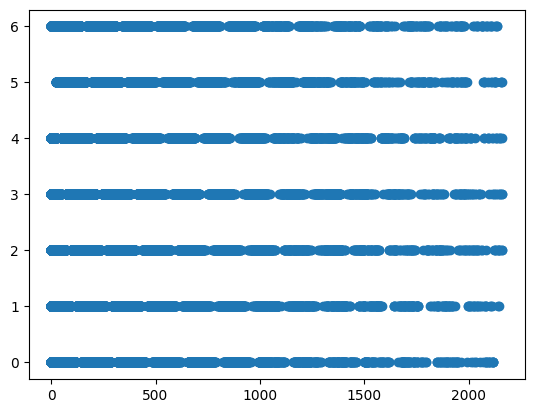

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(train['CI_HOUR'], train['weekday'])
plt.show()


## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


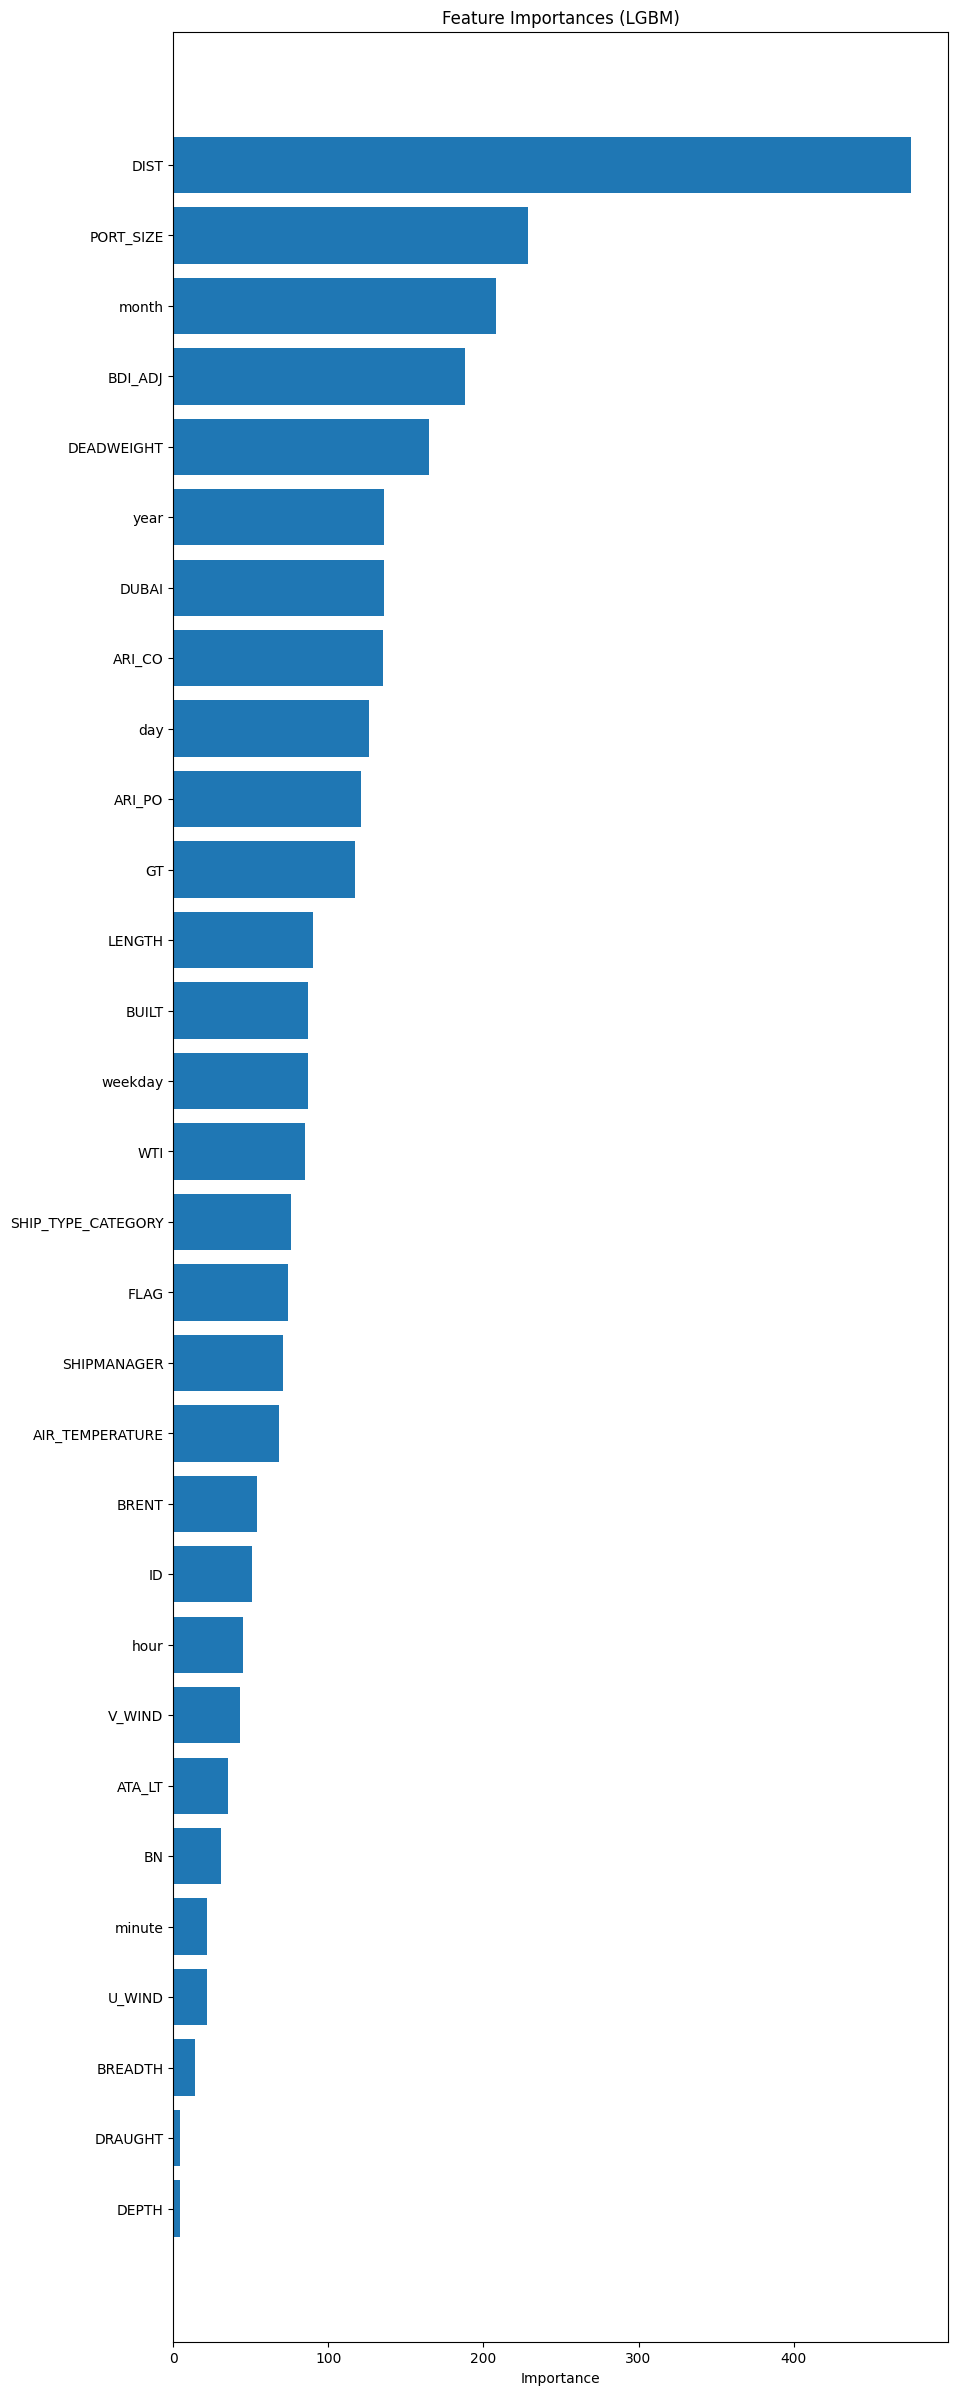

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [ ]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## K-Fold Model Fitting & Validation

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:01<00:04,  1.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:02<00:03,  1.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:03<00:02,  1.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:04<00:01,  1.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

Validation : MAE scores for each fold: [52.64372300947119, 54.21259302652475, 53.81358286835421, 53.27999456243711, 53.30398273099311]
Validation : MAE: 53.45077523955608


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)